In [1]:
import pandas as pd

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
stas = pd.read_csv('../DeconstructingGastrulation-Data/tracked_data.csv')

stas.head()

,Unnamed: 0.1,Unnamed: 0,x,y,z,frame,particle,dx,dy,dz
0,0,0,252.766403,24.680962,103.450500,1,0,NaN,NaN,NaN
1,1,1,252.504501,24.682747,103.450500,1,1,NaN,NaN,NaN
2,2,2,248.314102,24.750181,103.450500,1,2,NaN,NaN,NaN
3,3,3,247.528397,24.807440,109.474197,1,3,NaN,NaN,NaN
4,4,4,246.218903,24.629951,106.069504,1,4,NaN,NaN,NaN


In [3]:
import h5py
import numpy as np

with h5py.File('../CodePass2/runs/stas_comments_2.hdf5', 'r') as f:
    sim = np.array(f['x'])

    

In [4]:
# interactive plotting
import matplotlib.pyplot as plt
from IPython.display import HTML




C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\1817160276.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame1['x'] = frame1['x'] - frame1['x'].mean()-25
C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\1817160276.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame1['y'] = (frame1['y'] - frame1['y'].mean())*1.08
C:\Users\jakob\AppData\Local\Temp\ipykernel_38028\1817160276.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

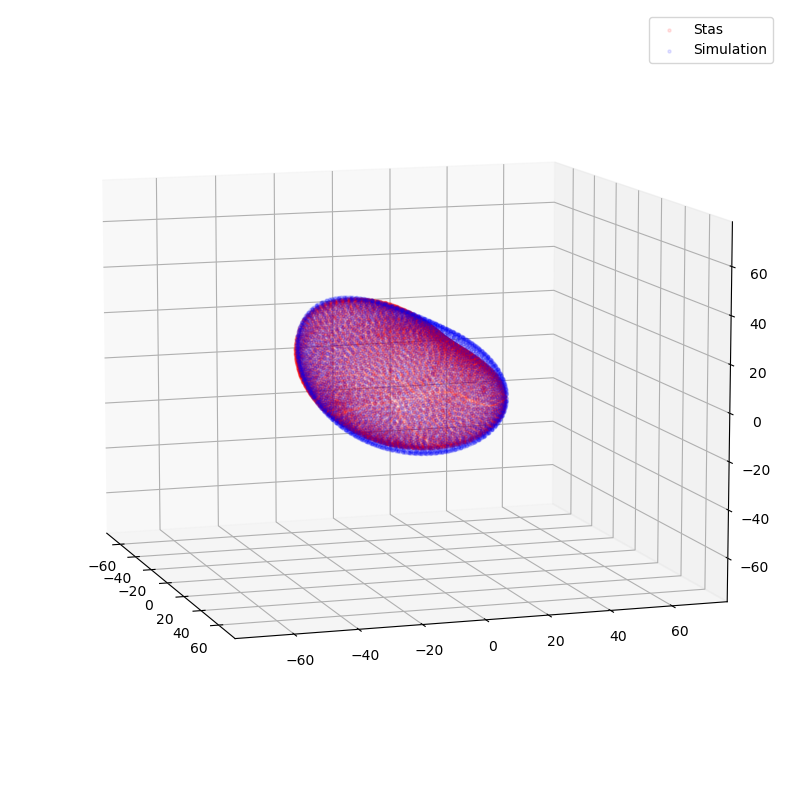

In [41]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# make animation
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d',)

frame1 = stas[stas['frame'] == 1]

frame1['x'] = frame1['x'] - frame1['x'].mean()-25
frame1['y'] = (frame1['y'] - frame1['y'].mean())*1.08
frame1['z'] = frame1['z'] - frame1['z'].mean()+10

# rotate 10 degrees around y axis
angle = -np.pi/180*8
frame1['x'], frame1['z'] = frame1['x']*np.cos(angle) - frame1['z']*np.sin(angle), frame1['x']*np.sin(angle) + frame1['z']*np.cos(angle)


s = 3.6


def func(i):
    ax.clear()
    ax.scatter(frame1['x']/s, frame1['y']/s, frame1['z']/s, c='r', marker='.', alpha = 0.1, label = 'Stas')

    x,y,z = sim[0].T


    ax.scatter(x, y, z, c='b', marker='.', alpha = 0.1, label = 'Simulation')

    plt.xlim(-75,75)
    plt.ylim(-75,75)
    ax.set_zlim(-75,75)

    # set the camera angle
    ax.view_init(elev=10, azim=i*360/20)

    plt.legend()
    return ax

ani = FuncAnimation(fig, func, frames=np.arange(0, 20), interval=100)

ani.save('comparison.mp4', writer='ffmpeg', fps=10)

plt.show()